## Czesc 1

In [1]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
random_state = 244827
n_samples = 2427

In [3]:
raw_x, raw_y = make_classification(n_samples=n_samples, random_state=random_state, n_features=2, n_clusters_per_class=1, n_informative=1, n_redundant=0, n_classes=2)
x_train, x_test, y_train, y_test = train_test_split(raw_x, raw_y, test_size=0.2, random_state=random_state, shuffle=True)

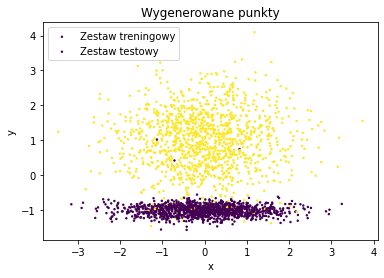

In [4]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# plt.scatter(raw_x[:, 0], raw_x[:, 1], c=raw_y, s=20, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], s=2, c=y_train, label='Zestaw treningowy')
plt.scatter(x_test[:, 0], x_test[:, 1], s=2, c=y_test, label='Zestaw testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Wygenerowane punkty")
plt.show()

In [5]:
# plt.scatter(x_train, y_train, s=2, c='b', label='Zestaw treningowy')
# plt.scatter(x_test, y_test, s=2, c='y', label='Zestaw testowy')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.title("Wygenerowane punkty")
# plt.show()


### Implementacja analityczna

In [6]:
# Kod kiedys

### Implementacja sklearn

In [7]:
model = RidgeClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)
y_predicted = model.predict(x_test)

In [8]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

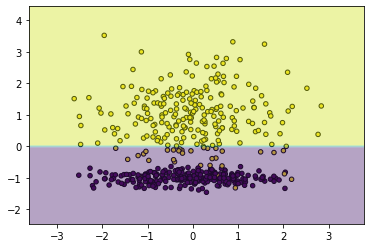

In [9]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=20, edgecolor="k")
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

In [10]:
cm = confusion_matrix(y_test, y_predicted)

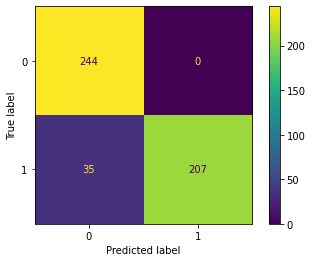

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [12]:
print(classification_report(y_test, y_predicted, labels=model.classes_))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       244
           1       1.00      0.86      0.92       242

    accuracy                           0.93       486
   macro avg       0.94      0.93      0.93       486
weighted avg       0.94      0.93      0.93       486



In [13]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specifity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(f'Czulość: {sensitivity}, swoistość: {specifity}')

Czulość: 1.0, swoistość: 0.8553719008264463
